In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [ ]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [ ]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [ ]:
sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

In [ ]:
%%time
reads_df = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

## Subset of reads with at least 3 SNPs 

In [7]:
%%time
dense_reads_with_detection_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        "high_quality_snp_positions_alleles",
        "high_quality_snps_idx_transitions",
        'CO_active_interval_start',
        'CO_active_interval_end',
        "CO_active_interval_length_bp",
        "CO_active_interval_start_cM",
        "CO_active_interval_end_cM",
        'NCO_active_interval_start',
        'NCO_active_interval_end',
        'NCO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'NCO_active_interval_start_cM',
        'NCO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        "full_read_crossover_prob",
        "mid_CO_active_interval_crossover_prob",
        'NCO_active_interval_crossover_prob',
        "NCO_prob_detection_in_CO_active_interval",
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'CL4_motif_center_pos',
        'CL4_heat',
        'CL4_motif_strand',
        'is_high_quality_read',
        "min_coverage_hap1",
        "min_coverage_hap2",
        "high_quality_classification_class",
        "snp_positions_on_read", 
        "idx_transitions",
        "high_quality_classification_in_detectable_class",
        "H3K4me3_signal_mean",
        "CTCF_signal_mean",
        "total_mismatches",
    )                  
    .collect()
    .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
)

CPU times: user 5min 35s, sys: 3min 46s, total: 9min 22s
Wall time: 4min 19s


In [9]:
%%time
read_name_to_double_mismatches_df = \
    pl.concat([
        pl.read_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/*/*/*/*/double_mismatches_per_read.parquet"
        ),
        pl.read_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/*/*/*/*/double_mismatches_per_read.parquet"
        ),
])
    

CPU times: user 33.8 s, sys: 10.8 s, total: 44.6 s
Wall time: 41.8 s


In [12]:
%%time
read_name_to_no_double_mismatches_df = \
    pl.concat([
        pl.read_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/*/*/*/*/prob_contamination_detection_per_read.parquet"
        ),
        pl.read_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/*/*/*/*/prob_contamination_detection_per_read.parquet"
        ),
])
    

CPU times: user 46 s, sys: 21.4 s, total: 1min 7s
Wall time: 1min 24s


In [13]:
read_name_to_no_double_mismatches_df.columns

['read_name',
 'log2_prob_panel_snps_not_in_read',
 'n_panel_snps_not_in_read',
 'n_AF>0.1_panel_snps_not_in_read']

In [14]:
len(read_name_to_no_double_mismatches_df)

248916179

In [22]:
(read_name_to_no_double_mismatches_df
    .select(
        (pl.col("n_panel_snps_not_in_read") >= 20).mean(),
        (pl.col("n_AF>0.1_panel_snps_not_in_read") >= 5).mean(),
    )
)

n_panel_snps_not_in_read,n_AF>0.1_panel_snps_not_in_read
f64,f64
0.812745,0.867807


In [78]:
%%time
# Take only reads with no evidence of contamination
dense_reads_with_detection_df = (dense_reads_with_detection_df
    .join(
        read_name_to_double_mismatches_df.filter(pl.col("n_double_mismatches_at_panel_snps") == 0), 
        on="read_name",
    )
    .join(
        read_name_to_no_double_mismatches_df.filter(pl.col("n_AF>0.1_panel_snps_not_in_read") >= 10), 
        on="read_name",
    )
)

CPU times: user 5min 36s, sys: 2min 36s, total: 8min 13s
Wall time: 1min 24s


In [24]:
len(dense_reads_with_detection_df)

81322375

# Add annotation for NCO reads only

In [25]:
NCO_df = (dense_reads_with_detection_df
    #.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter(pl.col("high_quality_classification_class") == "GC")
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch37_first_converted_marker_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
        grch38_first_converted_marker_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
            grch37_first_converted_marker_poses_rate = rate_map.get_rate(df["grch37_first_converted_marker_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
        )
    )
    
NCO_df = pl.concat(dfs)


# # of events, expected vs. observed

Carefully constrain the set of reads for this analysis:

* Only reads with sufficient coverage, to (over)account for the effect of filtering for coverage between switches
* Only high quality reads
* We allow 5 only SNPs
* We are looking for NCOs that happened in the "CO active interval" (2 SNPs each side)
* And only on high quality SNPs, since those are used for detection

In [26]:
possible_NCO_subset_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
    .filter("is_high_quality_read")
    .filter(pl.col("mid_CO_active_interval_crossover_prob") > 0)
    .filter(pl.col("min_coverage_hap1") >= 3)
    .filter(pl.col("min_coverage_hap2") >= 3)
)



In [27]:
def get_obs_exp(df, prob_CO_conversion):
    n_observed_NCOs = len(df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO"))
    
    ps = (
        df["CO_active_interval_crossover_prob"] *
        df["NCO_prob_detection_in_CO_active_interval"]
        / prob_CO_conversion * (1-prob_CO_conversion)
    ).to_numpy()

    # Expected is \sum_{p}
    mean_expected_NCOs = ps.sum()

    # Variance is \sum_{p(1-p)}
    std_expected_NCOs = (ps*(1-ps)).sum()**0.5
    
    return {
        "n_observed_NCOs": n_observed_NCOs,
        "mean_expected_NCOs": mean_expected_NCOs,
        "std_expected_NCOs": std_expected_NCOs,
    }
    
    

In [16]:
get_obs_exp(possible_NCO_subset_df, 0.12)

{'n_observed_NCOs': 787,
 'mean_expected_NCOs': np.float64(779.9033263373847),
 'std_expected_NCOs': np.float64(27.922701757933748)}

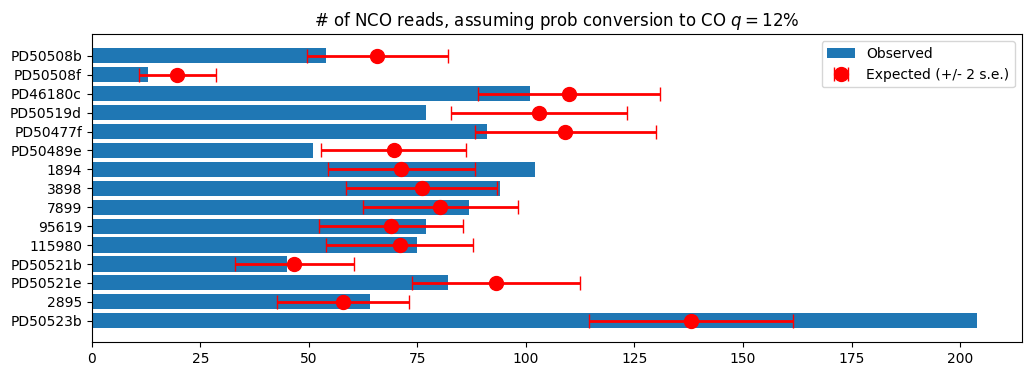

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))

for i, sample_id in enumerate(sample_presentation_order[:-1]):
    d = get_obs_exp(possible_NCO_subset_df.filter(pl.col("sample_id") == sample_id), 0.12)
    
    ax.barh(
        y = i,
        width = d["n_observed_NCOs"],
        color = "C0",        
    );
    
    ax.errorbar(
        x = d["mean_expected_NCOs"],
        y = i,
        xerr = d["std_expected_NCOs"] * 2,
        color = "red",
        ms = 10,
        fmt='o',
        elinewidth = 2,
        capsize = 5,
    );
    
ax.invert_yaxis()
ax.set_yticks(np.arange(len(sample_presentation_order[:-1])), sample_presentation_order[:-1]);
ax.legend(["Observed", "Expected (+/- 2 s.e.)"]);
ax.set_title("# of NCO reads, assuming prob conversion to CO $q=12\%$");
    

# Basic stats

In [29]:
upper_bound_mid = (NCO_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"].to_numpy()
)

In [30]:
print("Min:", np.min(upper_bound_mid))
print("Max:", np.max(upper_bound_mid))
print("Median:", np.median(upper_bound_mid))
print("Mean:", np.mean(upper_bound_mid))

Min: 39
Max: 19195
Median: 1688.0
Mean: 2393.0465577018326


In [31]:
conv_mid_df = (NCO_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select(pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

In [32]:
conv_mid_df

n_converted,len
i64,u32
1,1886
2,100
3,20
4,7
5,1
6,3
8,1
10,1


In [33]:
(NCO_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select("sample_id", pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("sample_id")
    .agg((pl.col("n_converted")>3).mean().alias("frac_n_converted_g3"))
    .sort("sample_id")
)

sample_id,frac_n_converted_g3
str,f64
"""115980""",0.0
"""1894""",0.0
"""2895""",0.0
"""3898""",0.006623
"""7899""",0.013793
"""95619""",0.018018
"""PD46180c""",0.005882
"""PD50477f""",0.006289
"""PD50489e""",0.009709


In [34]:
(NCO_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .with_columns(pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .filter(pl.col("n_converted") > 6)
    .select("n_converted", "read_name", "sample_id", "chrom")
    .sort("n_converted")
)

n_converted,read_name,sample_id,chrom
i64,str,str,str
8,"""m84053_230911_203330_s4/173867284/ccs""","""7899""","""chr14"""
10,"""m84047_240928_151025_s3/205264647/ccs""","""PD50523b""","""chr15"""


# Does it follow the model?

## In bp

### All read

In [22]:
N = 1e3

(dense_reads_with_detection_df
    .select(
        ((pl.col("read_length") // N).round() * N).alias("read_length_rounded_bp"),
        (pl.col("idx_transitions").list.len() == 2).cast(pl.Int32).alias("is_nco"),
    )
    .group_by("read_length_rounded_bp")
    .agg(pl.col("is_nco").mean())
    .sort("read_length_rounded_bp")
    .plot.scatter(x="read_length_rounded_bp", y="is_nco")
)

alt.Chart(...)

### Only detectable interval

In [18]:
N = 1e3

(dense_reads_with_detection_df
    .select(
        ((pl.col("CO_active_interval_length_bp") // N).round() * N).alias("detectable_interval_length_rounded_bp"),
        (
            pl.col("high_quality_classification_in_detectable_class").is_not_null() & \
            (pl.col("high_quality_classification_in_detectable_class") == "NCO")
        ).cast(pl.Int32).alias("is_nco"),
    )
    .group_by("detectable_interval_length_rounded_bp")
    .agg(pl.col("is_nco").mean())
    .sort("detectable_interval_length_rounded_bp")
    .plot.scatter(x="detectable_interval_length_rounded_bp", y="is_nco")
)

:Scatter   [detectable_interval_length_rounded_bp]   (is_nco)

## In cM

### All read

In [19]:
N = 1e-2

(dense_reads_with_detection_df
    .select(
        (((pl.col("grch37_reference_end_cM") - pl.col("grch37_reference_start_cM")) // N).round() * N).alias("read_length_rounded_cM"),
        (pl.col("idx_transitions").list.len() == 2).cast(pl.Int32).alias("is_nco"),
    )
    .group_by("read_length_rounded_cM")
    .agg(pl.col("is_nco").mean())
    .sort("read_length_rounded_cM")
    .plot.scatter(x="read_length_rounded_cM", y="is_nco")
)

:Scatter   [read_length_rounded_cM]   (is_nco)

### Only detectable interval

In [20]:
N = 1e-2

(dense_reads_with_detection_df
    .select(
        (((pl.col("CO_active_interval_end_cM") - pl.col("CO_active_interval_start_cM")) // N).round() * N).alias("detectable_interval_length_rounded_cM"),
        (
            pl.col("high_quality_classification_in_detectable_class").is_not_null() & \
            (pl.col("high_quality_classification_in_detectable_class") == "NCO")
        ).cast(pl.Int32).alias("is_nco"),
    )
    .group_by("detectable_interval_length_rounded_cM")
    .agg(pl.col("is_nco").mean())
    .sort("detectable_interval_length_rounded_cM")
    .plot.scatter(x="detectable_interval_length_rounded_cM", y="is_nco")
)

:Scatter   [detectable_interval_length_rounded_cM]   (is_nco)

In [21]:
1.5*5

7.5

# Overall rates

### cM/Mb at converted SNPs

In [35]:
np.nanmean(NCO_df["grch37_first_converted_marker_poses_rate"])*1e6

np.float64(15.124199520119463)

In [36]:
(NCO_df["grch37_cM_per_bp_across_recombining_interval"]*1e6).mean()

11.965875443012363

In [37]:
(NCO_df["full_read_crossover_prob"]*1e2 / NCO_df["read_length"] * 1e6).mean()



4.1601841786301925

### Do long NCOs follow the genetic map?

In [26]:
cm_at_short = np.log10(NCO_df
    .filter((pl.col("idx_transitions").list.get(0)+1) == (pl.col("idx_transitions").list.get(1)))
    ["CO_active_interval_crossover_prob"].to_numpy() * 1e2
)

cm_at_long = np.log10(NCO_df
    .filter((pl.col("idx_transitions").list.get(0)+1) != (pl.col("idx_transitions").list.get(1)))
    .filter(
        (pl.col("snp_positions_on_read").list.get((pl.col("idx_transitions").list.get(1))) - 
        pl.col("snp_positions_on_read").list.get((pl.col("idx_transitions").list.get(0)+1))) > 500
    )
    ["CO_active_interval_crossover_prob"].to_numpy() * 1e2
)

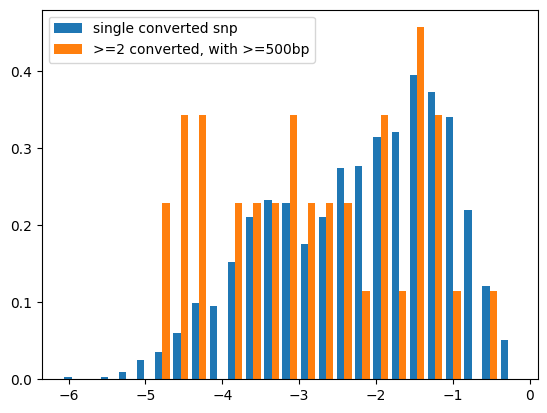

In [25]:
plt.hist(
    [cm_at_short,
     cm_at_long, 
    ],
     bins=25,
    density=True,
);

plt.legend(["single converted snp", ">=2 converted, with >=500bp"]);

### Compare to background

In [38]:
(dense_reads_with_detection_df
    .select(pl.col("CO_active_interval_crossover_prob")*1e2 / pl.col("CO_active_interval_length_bp") * 1e6)
).mean()

CO_active_interval_crossover_prob
f64
1.210156


# BQ differences in converted SNPs?

In [10]:
len(NCO_df)

2767

In [12]:
%%time
import glob
nco_ann_snps_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212") / \
                f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .join(
            (NCO_df
                .filter(pl.col("sample_id") == sample_id)
                .select("read_name", "sample_id")
                .lazy()
            ),
            on=["read_name", "sample_id"],
        )
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(rahbari_df.iter_rows())
#        if sample_id in ["PD50523b", "PD50477f"]
])



0it [00:00, ?it/s]
1it [00:40, 40.91s/it]
2it [00:47, 20.54s/it]
3it [01:01, 17.59s/it]
4it [01:16, 16.80s/it]
5it [01:29, 15.47s/it]
6it [02:23, 28.32s/it]
7it [03:09, 34.22s/it]
8it [03:56, 38.28s/it]
9it [04:48, 42.69s/it]
10it [04:54, 31.12s/it]
11it [05:05, 25.06s/it]
12it [05:12, 19.67s/it]
13it [05:18, 15.48s/it]
14it [06:08, 25.88s/it]
15it [06:55, 32.22s/it]
16it [07:48, 38.40s/it]
17it [08:30, 39.50s/it]
18it [08:36, 29.56s/it]
19it [08:43, 22.77s/it]
20it [08:51, 18.26s/it]
21it [09:32, 24.97s/it]
22it [10:05, 27.61s/it]
23it [10:21, 23.89s/it]
24it [10:31, 19.73s/it]
25it [11:20, 28.64s/it]
26it [11:55, 30.54s/it]
27it [12:48, 37.26s/it]
28it [13:56, 46.60s/it]
29it [14:48, 48.04s/it]
30it [14:55, 35.69s/it]
31it [15:08, 28.97s/it]
32it [15:10, 21.01s/it]
33it [15:17, 16.65s/it]
34it [15:59, 24.20s/it]
35it [16:38, 28.68s/it]
36it [17:16, 31.53s/it]
37it [17:23, 24.17s/it]
38it [17:29, 18.78s/it]
39it [17:35, 14.89s/it]
40it [17:40, 12.05s/it]
41it [18:24, 21.40s/it]
42it 

CPU times: user 41min 16s, sys: 7min 53s, total: 49min 9s
Wall time: 25min 37s


In [22]:
converted_snps_df = (nco_ann_snps_df
    .group_by("sample_id", "read_name", "op1", "op2")
    .agg(
        mean_qual = pl.col("qual_start1").mean(),
        n_snps_per_side = pl.col("qual_start1").len(),
    )
    .filter((pl.col("op1") == 7) | (pl.col("op2") == 7))
    .sort("read_name", "n_snps_per_side")
    .unique(subset=["read_name"], keep="first")
)

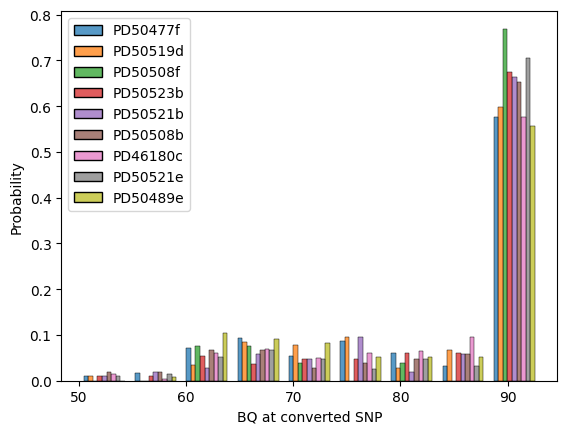

In [36]:
sns.histplot([
    pd.Series(converted_snps_df.filter(pl.col("sample_id") == sample_id)["mean_qual"], name=sample_id)
        for sample_id in rahbari_sample_ids
],
    stat="probability",
    multiple="dodge",
    bins=np.linspace(50, 93, 10),
    legend=True,
    shrink=0.8,
    common_norm=False,
)
plt.xlabel("BQ at converted SNP");

# "Contamination"?

In [12]:
%%time
import glob
nco_ann_snps_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212") / \
                f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .join(
            (NCO_df
                .filter(pl.col("sample_id") == sample_id)
                .select("read_name", "sample_id")
                .lazy()
            ),
            on=["read_name", "sample_id"],
        )
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(rahbari_df.iter_rows())
#        if sample_id in ["PD50523b", "PD50477f"]
])


56it [29:50, 31.97s/it]

CPU times: user 41min 24s, sys: 7min 46s, total: 49min 11s
Wall time: 29min 50s


In [31]:
(nco_ann_snps_df
#    .filter(pl.col("qual_start1") >= 93)
    .group_by("sample_id", "read_name", "read_length1")
    .agg(
        (pl.col("op1") == pl.col("op2")).sum().alias("n_both_mismatch"),
        ((pl.col("op1") == pl.col("op2")).sum() / pl.col("read_length1").first()).alias("n_both_mismatch_per_bp"),
    )
    .group_by("sample_id")
    .agg(
        mean_n_both_mismatches = pl.col("n_both_mismatch").mean(),
        mean_n_both_mismatches_per_bp = pl.col("n_both_mismatch_per_bp").mean(),
    )
    .sort("mean_n_both_mismatches_per_bp")
)

sample_id,mean_n_both_mismatches,mean_n_both_mismatches_per_bp
str,f64,f64
"""PD50508f""",0.5,0.000034
"""PD50519d""",1.730769,0.000169
"""PD50521b""",2.182692,0.000181
"""PD50477f""",1.601064,0.00021
"""PD46180c""",2.874525,0.000284
"""PD50523b""",2.959943,0.000307
"""PD50508b""",2.915888,0.000331
"""PD50521e""",3.09596,0.000378
"""PD50489e""",3.784173,0.000508


# Genetic length vs. tract length?

In [39]:
test_df = (NCO_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ).alias("upper_bound"),
        (pl.col("grch37_reference_end_cM") - pl.col("grch37_reference_start_cM")).alias("read_length_cM"),
    )
)
 

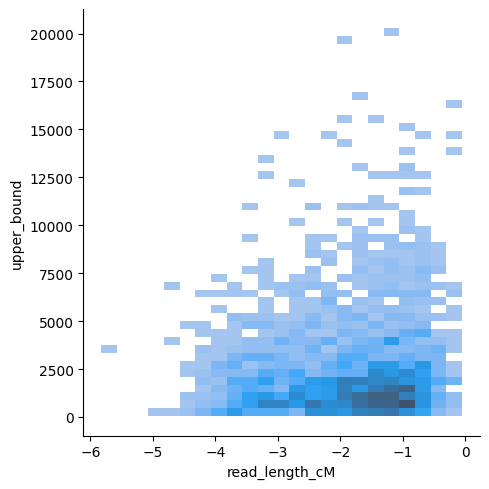

In [40]:
sns.displot(
    x=test_df["read_length_cM"].log10(),
    y=test_df["upper_bound"],
)

In [41]:
scipy.stats.spearmanr(
    test_df["read_length_cM"].log10(),
    test_df["upper_bound"],
)

SignificanceResult(statistic=np.float64(0.10200936688257489), pvalue=np.float64(1.2230861992728201e-05))

<Axes: ylabel='Probability'>

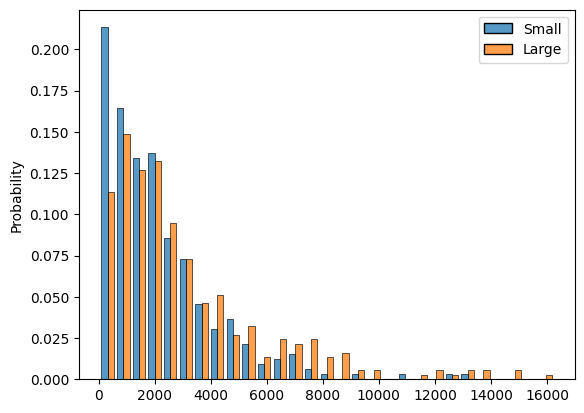

In [42]:
sns.histplot(
    [
        test_df.filter(pl.col("read_length_cM").log10() < -3)["upper_bound"].alias("Small"),
        test_df.filter(pl.col("read_length_cM").log10() >= -1)["upper_bound"].alias("Large"),
    ],
    common_norm = False,
    stat = "probability",
    multiple = "dodge",
    shrink = 0.8,
)

# Check NCO differences between samples

## In detectable interval

In [44]:
pairwise_nco_df = inference.get_sample_pairwise_tests(
    sample_ids,
    NCO_df, 
    "CO_active_interval_crossover_prob",
    n_perms = 1000,
    take_log10 = False,
)

100%|██████████| 105/105 [00:29<00:00,  3.59it/s]


In [45]:
pairwise_nco_df.sort("AD_perm_pvalue").head(10)

sample_id1,sample_id2,paper_label_id1,paper_label_id2,n1,n2,ks_pvalue,AD_perm_pvalue
str,str,str,str,i64,i64,f64,f64
"""1894""","""3898""","""AA5""","""AA6""",149,151,0.000209,0.0
"""1894""","""PD50477f""","""AA5""","""AA3""",149,159,0.000056,0.0
"""1894""","""PD50521b""","""AA5""","""AN-s1""",149,74,0.000764,0.0
"""2895""","""PD50523b""","""AB""","""AD""",105,316,0.001435,0.0
"""3898""","""PD50523b""","""AA6""","""AD""",151,316,0.000026,0.0
"""7899""","""PD50523b""","""AA7""","""AD""",145,316,0.000389,0.0
"""95619""","""PD50523b""","""AA8""","""AD""",111,316,0.00007,0.0
"""PD50477f""","""PD50489e""","""AA3""","""AA4""",159,103,0.000499,0.0
"""PD50477f""","""PD50523b""","""AA3""","""AD""",159,316,6.8125e-9,0.0


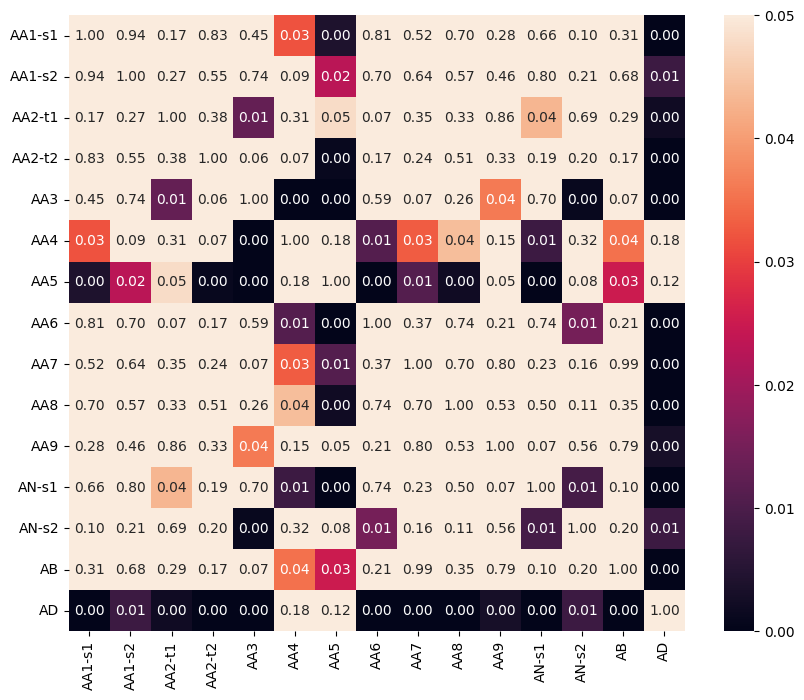

In [46]:
inference.plot_pairwise_results(
    pairwise_nco_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

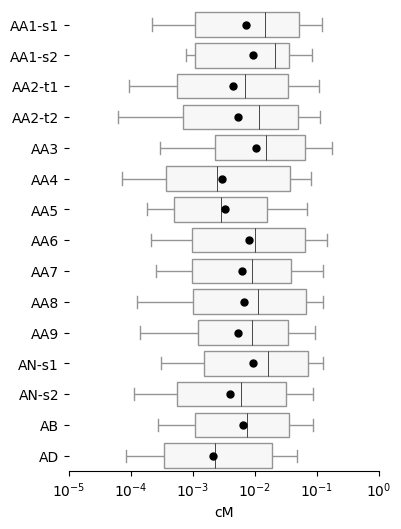

In [47]:
ax = inference.plot_boxplots_samples(
    NCO_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    xlabel = "cM",
    take_log10=True,
    figsize=(4, 6),
    ticks = np.arange(-5, 1),
    label_to_color={
        # "AA5": NCO_color,
        # "AA2-t2": NCO_color,
    }
);


In [49]:
inference.get_sample_vs_rest_tests(
    [s for s in rahbari_sample_ids if sample_id_to_paper_label[s]],
    NCO_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    n_perms = 100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   50.6s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   50.7s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   50.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   50.7s remaining:   40.6s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   50.8s remaining:   25.4s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   50.8s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   51.0s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD46180c""","""AA2-t1""",170,0.0,0.8,0.742902
"""PD50477f""","""AA3""",159,0.0,0.0,2.3871e-7
"""PD50489e""","""AA4""",103,0.0,0.17,0.818136
"""PD50508b""","""AA1-s1""",93,0.0,0.1,0.406965
"""PD50521b""","""AN-s1""",74,0.0,0.02,0.099155
"""PD50521e""","""AN-s2""",162,0.0,0.43,0.09765
"""PD50523b""","""AD""",316,0.0,0.0,0.000003
"""PD50519d""","""AA2-t2""",140,0.01,0.22,0.821434
"""PD50508f""","""AA1-s2""",24,0.12,0.3,0.933334


In [43]:
inference.get_sample_vs_rest_tests(
    [s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AD"]],
    NCO_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    n_perms = 100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    3.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    3.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.1s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD46180c""","""AA2-t1""",263,0.0,0.02,0.089445
"""PD50477f""","""AA3""",188,0.0,0.0,0.000002
"""PD50489e""","""AA4""",139,0.0,0.0,0.466551
"""PD50508b""","""AA1-s1""",107,0.0,0.08,0.679714
"""PD50521e""","""AN-s2""",198,0.0,0.3,0.030182
"""PD50519d""","""AA2-t2""",182,0.03,0.9,0.610029
"""PD50521b""","""AN-s1""",104,0.05,0.56,0.744575
"""PD50508f""","""AA1-s2""",28,0.52,0.66,0.856248


In [45]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s]],
    NCO_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    n_perms = 100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   37.8s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   37.8s remaining:   37.8s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   37.8s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   37.8s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""1894""","""AA5""",162,0.0,0.0,0.021888
"""3898""","""AA6""",162,0.01,0.03,0.015699
"""95619""","""AA8""",125,0.09,0.36,0.319746
"""2895""","""AB""",117,0.33,0.67,0.747409
"""115980""","""AA9""",132,0.37,0.92,0.549789
"""7899""","""AA7""",161,0.43,1.0,0.852177


In [46]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AA5"]],
    NCO_df.with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2),
    "cM",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""3898""","""AA6""",162,0.163,0.084,0.06486
"""2895""","""AB""",117,0.688,0.521,0.459831
"""115980""","""AA9""",132,0.748,0.594,0.297517
"""95619""","""AA8""",125,0.753,0.638,0.599498
"""7899""","""AA7""",161,0.896,0.9,0.482295


## In detectable interval - only with classification in detectable/

In [35]:
pairwise_nco_df = inference.get_sample_pairwise_tests(
    sample_ids,
    NCO_df.filter(pl.col("high_quality_classification_in_detectable_class").is_not_null()),
    "CO_active_interval_crossover_prob",
    n_perms = 1000,
    take_log10 = False,
)

100%|██████████| 105/105 [00:24<00:00,  4.20it/s]


In [36]:
pairwise_nco_df.sort("AD_perm_pvalue").head(10)

sample_id1,sample_id2,paper_label_id1,paper_label_id2,n1,n2,ks_pvalue,AD_perm_pvalue
str,str,str,str,i64,i64,f64,f64
"""1894""","""3898""","""AA5""","""AA6""",162,128,0.000104,0.0
"""1894""","""PD50521b""","""AA5""","""AN-s1""",162,54,0.00001,0.0
"""1894""","""PD50521e""","""AA5""","""AN-s2""",162,37,0.000733,0.001
"""1894""","""PD50523b""","""AA5""","""AD""",162,60,0.000513,0.001
"""PD50519d""","""PD50523b""","""AA2-t2""","""AD""",44,60,0.008268,0.002
"""1894""","""7899""","""AA5""","""AA7""",162,139,0.0004,0.003
"""3898""","""PD50519d""","""AA6""","""AA2-t2""",128,44,0.016406,0.003
"""115980""","""3898""","""AA9""","""AA6""",114,128,0.060767,0.005
"""1894""","""PD50477f""","""AA5""","""AA3""",162,30,0.023094,0.007


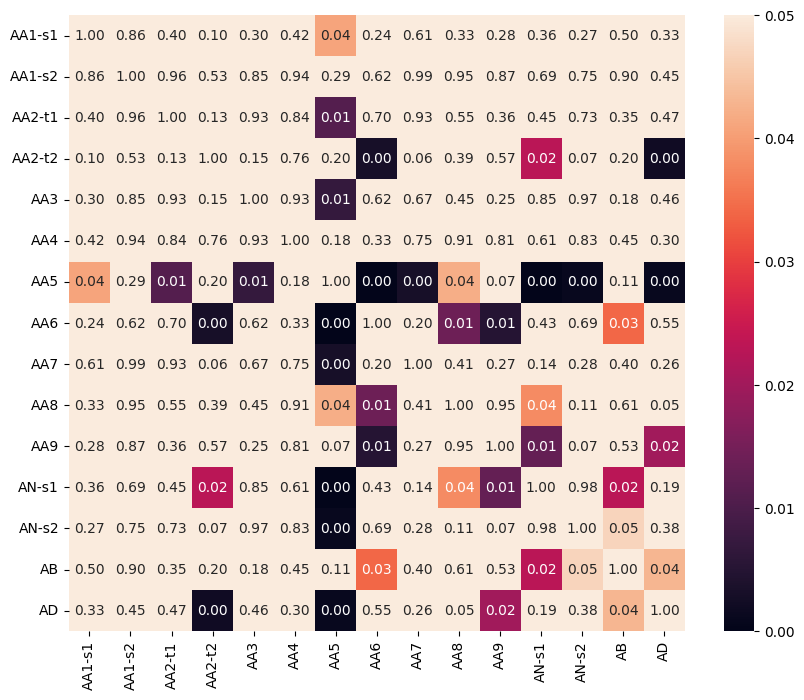

In [37]:
inference.plot_pairwise_results(
    pairwise_nco_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

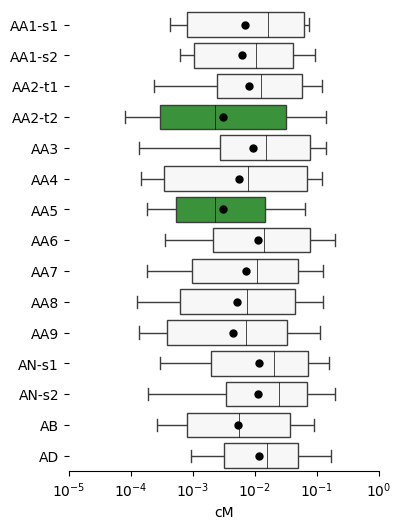

In [38]:
ax = inference.plot_boxplots_samples(
    (NCO_df
        .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
        .with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2)
    ),
    "cM",
    xlabel = "cM",
    take_log10=True,
    figsize=(4, 6),
    ticks = np.arange(-5, 1),
    label_to_color={
        "AA5": NCO_color,
        "AA2-t2": NCO_color,
    }
);


### Test one sample vs the rest

In [39]:
sample_vs_rest_df = inference.get_sample_vs_rest_tests(
    sample_id_order,
    NCO_df,
    "CO_active_interval_crossover_prob",
    n_perms=100,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    0.7s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:    0.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:    0.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapse

In [40]:
sample_vs_rest_df.sort("AD_perm_pvalue")

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""115980""","""AA9""",173,0.0,0.81,0.957661
"""1894""","""AA5""",224,0.0,0.0,0.000171
"""2895""","""AB""",147,0.0,0.46,0.779732
"""3898""","""AA6""",199,0.0,0.0,0.025775
"""7899""","""AA7""",206,0.0,0.76,0.85523
"""95619""","""AA8""",161,0.0,0.93,0.89331
"""PD50508b""","""AA1-s1""",43,0.0,0.2,0.925841
"""PD50519d""","""AA2-t2""",76,0.0,0.0,0.211063
"""PD50521b""","""AN-s1""",82,0.0,0.07,0.094143


In [41]:
sample_vs_rest_except_df = inference.get_sample_vs_rest_tests(
    [k for k,v in sample_id_to_paper_label.items() if v not in ["AA5", "AA2-t2"]],
    NCO_df,
    "CO_active_interval_crossover_prob",
    n_perms=10000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03836536407470703s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of  16 | elapsed:   43.0s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:   49.8s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of  16 | elapsed:   54.8s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   57.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of  16 | elapsed:   59.3s remaining:   59.3s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   59.8s remaining:   46.5s
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:  1.0min remaining:   37.6s
[Parallel(n_jobs=-1)]: Done  11 out 

In [42]:
sample_vs_rest_except_df.sort("AD_perm_pvalue")

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""3898""","""AA6""",199,0.0683,0.0529,0.141757
"""2895""","""AB""",147,0.0685,0.1407,0.762527
"""PD50489e""","""AA4""",40,0.1128,0.138,0.727957
"""PD50521e""","""AN-s2""",57,0.1742,0.1899,0.260839
"""115980""","""AA9""",173,0.1828,0.2038,0.498502
"""PD50521b""","""AN-s1""",82,0.432,0.2062,0.237019
"""95619""","""AA8""",161,0.4834,0.4766,0.465707
"""PD50508b""","""AA1-s1""",43,0.6331,0.385,0.835732
"""7899""","""AA7""",206,0.7262,0.8862,0.384982


In [72]:
def plot_cm_diffs(
    label_list1,
    label_list2,
    label_legend1 = "",
    label_legend2 = "",
    ax = None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    sample_ids1 = [k for k,v in sample_id_to_paper_label.items() if v in label_list1]
    sample_ids2 = [k for k,v in sample_id_to_paper_label.items() if v in label_list2]
    
    if label_legend1 == "":
        label_legend1 = ', '.join(sample_ids1)
    if label_legend2 == "":
        label_legend2 = ', '.join(sample_ids1)

    x1 = pd.Series(np.log10(NCO_df.filter(pl.col("sample_id").is_in(sample_ids1))["CO_active_interval_crossover_prob"] * 1e2), name=label_legend1)
    x2 = pd.Series(np.log10(NCO_df.filter(pl.col("sample_id").is_in(sample_ids2))["CO_active_interval_crossover_prob"] * 1e2), name=label_legend2)

    sns.histplot(
        data = [x1, x2],
        bins=25, #np.linspace(0, 2, 25),
        multiple="dodge",
        shrink=0.8,
        stat="proportion",
        common_norm=False,
        ax=ax,
    )
    
    sns.despine(ax=ax)

    ax.set_xlabel("Genetic length (cM)");
    ax.set_xticks(
        ticks = np.arange(-7, 1),
        labels = [f"$10^{{{x}}}$" for x in np.arange(-7, 1)],
    );

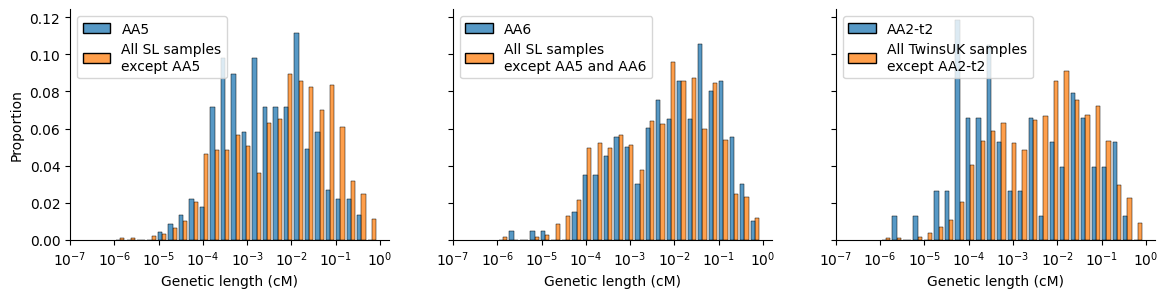

In [83]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3), sharex=True, sharey=True)

plot_cm_diffs(
    ["AA5"],
    [label for sample_id, label in sample_id_to_paper_label.items() \
         if sample_id in sudmant_sample_ids and label not in ["AA5"]],
    label_legend1 = "AA5",
    label_legend2 = "All SL samples\nexcept AA5",
    ax = axs[0],
)

plot_cm_diffs(
    ["AA6"],
    [label for sample_id, label in sample_id_to_paper_label.items() \
         if sample_id in sudmant_sample_ids and label not in ["AA5", "AA6"]],
    label_legend1 = "AA6",
    label_legend2 = "All SL samples\nexcept AA5 and AA6",
    ax = axs[1],
)

plot_cm_diffs(
    ["AA2-t2"],
    [label for sample_id, label in sample_id_to_paper_label.items() \
         if sample_id in sudmant_sample_ids and label not in ["AA2-t2"]],
    label_legend1 = "AA2-t2",
    label_legend2 = "All TwinsUK samples\nexcept AA2-t2",
    ax = axs[2],
)

## At converted SNP

In [45]:
pairwise_nco_conv_df = inference.get_sample_pairwise_tests(
    sample_ids,
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
    take_log10 = False,
)

100%|██████████| 105/105 [00:47<00:00,  2.20it/s]


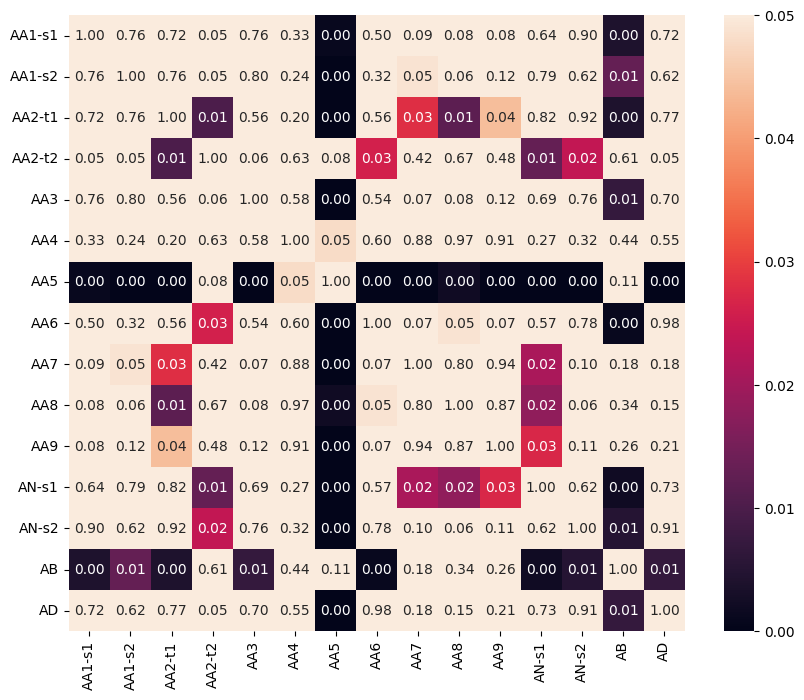

In [46]:
inference.plot_pairwise_results(
    pairwise_nco_conv_df,
    sample_presentation_order[:-1],
    column = "AD_perm_pvalue",
    vmax = 0.05,
    show_paper_labels = True,
)

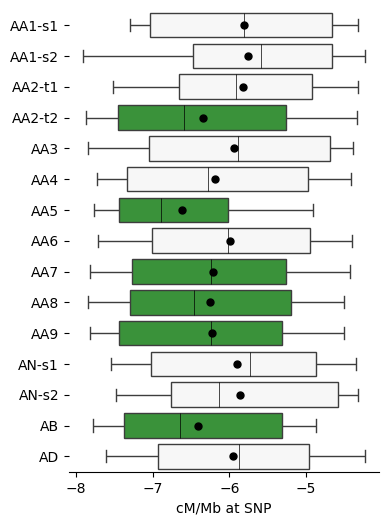

In [47]:
ax = inference.plot_boxplots_samples(
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    xlabel = "cM/Mb at SNP",
    take_log10=True,
    figsize=(4, 6),
#    ticks = np.arange(-5, 1),
    label_to_color={
        "AA5": NCO_color,
        "AB": NCO_color,
        "AA2-t2": NCO_color,
        "AA7": NCO_color,
        "AA8": NCO_color,
        "AA9": NCO_color,
    }
);


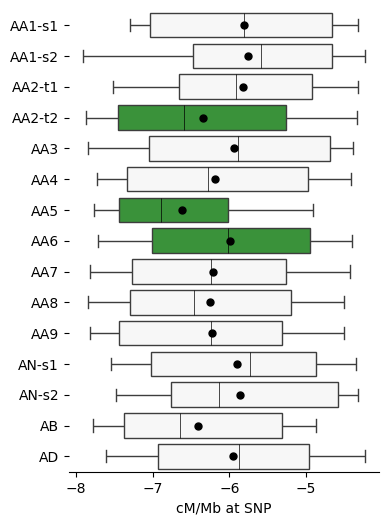

In [48]:
ax = inference.plot_boxplots_samples(
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    xlabel = "cM/Mb at SNP",
    take_log10=True,
    figsize=(4, 6),
#    ticks = np.arange(-5, 1),
    label_to_color={
        "AA5": NCO_color,
        "AA6": NCO_color,
        "AA2-t2": NCO_color,
    }
);


In [49]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AB", "AA5"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:   12.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of  13 | elapsed:   13.5s remaining:   45.2s
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:   14.2s remaining:   32.0s
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:   14.9s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   6 out of  13 | elapsed:   15.1s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:   15.1s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:   15.3s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   9 out of  13 | elapsed:   15.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:   15.8s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:   16.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapse

sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50519d""","""AA2-t2""",76,0.0,0.053,NaN
"""7899""","""AA7""",206,0.003,0.104,NaN
"""95619""","""AA8""",161,0.004,0.091,NaN
"""115980""","""AA9""",173,0.021,0.166,NaN
"""PD50521b""","""AN-s1""",82,0.03,0.1,NaN
"""PD46180c""","""AA2-t1""",62,0.035,0.13,NaN
"""3898""","""AA6""",199,0.086,0.303,NaN
"""PD50508f""","""AA1-s2""",29,0.193,0.209,NaN
"""PD50508b""","""AA1-s1""",43,0.252,0.27,NaN


In [50]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AB", "AA5", "AA2-t2"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    5.6s remaining:   27.9s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    6.0s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    6.2s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    6.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    6.8s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    6.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:    7.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    7.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    8.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.4s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""95619""","""AA8""",161,0.0,0.044,NaN
"""7899""","""AA7""",206,0.006,0.047,NaN
"""115980""","""AA9""",173,0.017,0.105,NaN
"""PD50521b""","""AN-s1""",82,0.107,0.124,NaN
"""PD46180c""","""AA2-t1""",62,0.115,0.152,NaN
"""3898""","""AA6""",199,0.296,0.469,NaN
"""PD50508f""","""AA1-s2""",29,0.34,0.219,NaN
"""PD50508b""","""AA1-s1""",43,0.459,0.261,NaN
"""PD50521e""","""AN-s2""",57,0.53,0.309,NaN


In [51]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AB", "AA5", "AA2-t2", "AA8"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    3.7s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   3 out of  11 | elapsed:    4.1s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    4.2s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:    4.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    4.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:    4.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    4.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    4.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.3s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""7899""","""AA7""",206,0.0,0.011,NaN
"""115980""","""AA9""",173,0.003,0.042,NaN
"""PD50521b""","""AN-s1""",82,0.303,0.185,NaN
"""PD46180c""","""AA2-t1""",62,0.405,0.246,NaN
"""PD50508f""","""AA1-s2""",29,0.472,0.278,NaN
"""3898""","""AA6""",199,0.508,0.645,NaN
"""PD50508b""","""AA1-s1""",43,0.632,0.359,NaN
"""PD50489e""","""AA4""",40,0.672,0.713,NaN
"""PD50477f""","""AA3""",64,0.722,0.422,NaN


In [52]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AB", "AA5", "AA2-t2", "AA8", "AA7"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    2.7s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.9s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    4.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.3s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""115980""","""AA9""",173,0.006,0.013,NaN
"""PD50489e""","""AA4""",40,0.569,0.531,NaN
"""PD50521b""","""AN-s1""",82,0.641,0.358,NaN
"""PD46180c""","""AA2-t1""",62,0.714,0.406,NaN
"""3898""","""AA6""",199,0.718,0.863,NaN
"""PD50508f""","""AA1-s2""",29,0.747,0.403,NaN
"""PD50508b""","""AA1-s1""",43,0.832,0.453,NaN
"""PD50477f""","""AA3""",64,0.899,0.562,NaN
"""PD50521e""","""AN-s2""",57,0.91,0.633,NaN


In [53]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AB", "AA5", "AA2-t2", "AA8", "AA7", "AA9"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    2.3s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.4s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    2.4s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    2.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.5s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50489e""","""AA4""",40,0.457,0.323,0.423634
"""PD50508f""","""AA1-s2""",29,0.899,0.53,0.163026
"""3898""","""AA6""",199,0.92,0.597,0.178573
"""PD46180c""","""AA2-t1""",62,0.942,0.693,0.751239
"""PD50521b""","""AN-s1""",82,0.943,0.567,0.606401
"""PD50508b""","""AA1-s1""",43,0.966,0.595,0.104691
"""PD50477f""","""AA3""",64,0.982,0.627,0.396775
"""PD50521e""","""AN-s2""",57,0.985,0.858,0.639846
"""PD50523b""","""AD""",79,0.992,0.962,0.996444


### Between groups

In [54]:
inference.get_sample_vs_rest_tests(
    [s for s in rahbari_sample_ids if sample_id_to_paper_label[s]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    2.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    2.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    2.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.2s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50519d""","""AA2-t2""",76,0.0,0.005,0.983665
"""PD46180c""","""AA2-t1""",62,0.422,0.408,0.578817
"""PD50489e""","""AA4""",40,0.469,0.459,0.346319
"""PD50521b""","""AN-s1""",82,0.487,0.373,0.431586
"""PD50508f""","""AA1-s2""",29,0.702,0.487,0.268661
"""PD50508b""","""AA1-s1""",43,0.736,0.591,0.201191
"""PD50521e""","""AN-s2""",57,0.753,0.726,0.855859
"""PD50523b""","""AD""",79,0.811,0.963,0.766191
"""PD50477f""","""AA3""",64,0.835,0.727,0.605847


In [55]:
inference.get_sample_vs_rest_tests(
    [s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AA2-t2"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""PD50489e""","""AA4""",40,0.387,0.241,0.339675
"""PD50508f""","""AA1-s2""",29,0.922,0.67,0.265097
"""PD46180c""","""AA2-t1""",62,0.951,0.767,0.570811
"""PD50521b""","""AN-s1""",82,0.951,0.607,0.420321
"""PD50508b""","""AA1-s1""",43,0.968,0.714,0.196736
"""PD50477f""","""AA3""",64,0.972,0.714,0.602274
"""PD50523b""","""AD""",79,0.984,0.886,0.759109
"""PD50521e""","""AN-s2""",57,0.985,0.875,0.856091


In [56]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    2.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.1s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""1894""","""AA5""",224,0.0,0.0,NaN
"""3898""","""AA6""",199,0.0,0.0,NaN
"""7899""","""AA7""",206,0.0,0.39,NaN
"""2895""","""AB""",147,0.004,0.293,NaN
"""115980""","""AA9""",173,0.008,0.413,NaN
"""95619""","""AA8""",161,0.027,0.921,NaN


In [57]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AA5"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""3898""","""AA6""",199,0.0,0.004,NaN
"""2895""","""AB""",147,0.008,0.034,NaN
"""7899""","""AA7""",206,0.303,0.771,NaN
"""95619""","""AA8""",161,0.34,0.792,NaN
"""115980""","""AA9""",173,0.406,0.825,NaN


In [58]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AA5", "AA6"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""2895""","""AB""",147,0.224,0.168,NaN
"""7899""","""AA7""",206,0.7,0.613,NaN
"""115980""","""AA9""",173,0.819,0.738,NaN
"""95619""","""AA8""",161,0.841,0.893,NaN


In [59]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AA6"]],
    NCO_df,
    "grch37_first_converted_marker_poses_rate",
    n_perms = 1000,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


sample_id,paper_label_id,n_in_sample,AD_perm_pvalue,AD_perm_pvalue_agg,ttest_pvalue_agg
str,str,i64,f64,f64,f64
"""1894""","""AA5""",224,0.0,0.0,NaN
"""7899""","""AA7""",206,0.007,0.066,NaN
"""115980""","""AA9""",173,0.011,0.12,NaN
"""95619""","""AA8""",161,0.052,0.378,NaN
"""2895""","""AB""",147,0.151,0.708,NaN


# DSBs

## Overall rates

### A/A

In [50]:
print("Fraction of NCO reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .filter(pl.col("high_quality_classification_class") == "GC")
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of NCO reads with motif in them: 0.4764735017335314


In [51]:
print("Fraction of all reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of all reads with motif in them: 0.14695422889954918


In [52]:
print("Fraction of NCO reads with motif in active region:", (NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .select(
        (pl.col("grch38_recombining_interval_start_pos") <= pl.col("AA_motif_center_pos")) &
        (pl.col("grch38_recombining_interval_end_pos") > pl.col("AA_motif_center_pos"))
    )
    .mean().item(0,0)
))

Fraction of NCO reads with motif in active region: 0.6174636174636174


## Overall distances to motif center

### Using the whole recombining interval

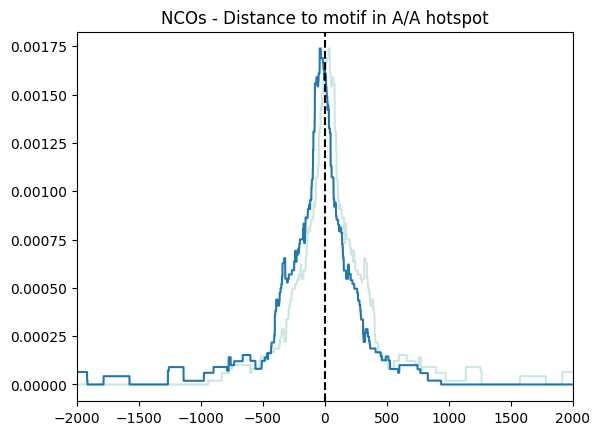

In [29]:
xs, H = inference.calculate_motif_distance_histogram(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    grch38_recombining_interval_threshold=500,
)

plt.plot(xs, H);
plt.plot(xs, H[::-1], color="teal", alpha=0.2);
plt.title("NCOs - Distance to motif in A/A hotspot");
plt.xlim(-2000,2000);
plt.axvline(0, color="black", ls="--");

In [30]:
inference.motif_distance_histogram_symmetry_permutation_testing(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    grch38_recombining_interval_threshold=500,
)

np.float64(0.017)

### Use just converted SNPs

#### No weighting by signal

In [53]:
def grenander(data, p, k):
    n = len(data)
    assert (k > 0) and (k < n - 1)

    data = np.sort(data).astype(float)
    diff = data[k:] - data[:-k]
    tot = data[k:] + data[:-k]

    # Limiting value
    if np.any(diff == 0):
        return np.nanmean(np.where(diff == 0, tot, np.nan)) / 2

    b = (tot / diff**p).sum() / 2
    a = (1 / diff**p).sum()

    assert np.isfinite(b / a), f"b/a not finite: {b}/{a}, p={p}, k={k}"

    return b / a


def estimate_mode(data):
    p = 10
    k = int(len(data) / 2)
    return grenander(data, p, k)

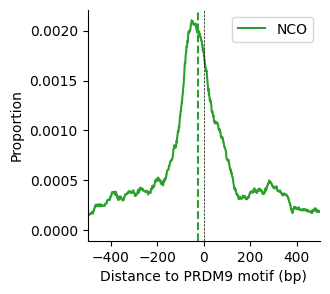

In [54]:
xs, H = inference.calculate_motif_distance_to_converted_snps_histogram(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

n_reads = len(NCO_df.filter(pl.col("AA_motif_center_pos").is_not_null()))
est_mode = estimate_mode(np.concatenate([[x]*int(cnt) for x, cnt in zip(xs, H*n_reads) if cnt]))

#plt.plot(xs, H, alpha=0.8);
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(
    xs,
    scipy.ndimage.uniform_filter1d(H, 100),
    color=NCO_color,
    label="NCO",
)
#plt.plot(xs, H[::-1], color="teal", alpha=0.2);
#plt.title("NCOs - Distance to motif in A/A hotspot");
ax.set_xlim(-500,500);
ax.axvline(0, color="black", ls="--", lw=0.5, alpha=1);
ax.axvline(est_mode, color=NCO_color, ls="--");
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel("Distance to PRDM9 motif (bp)");
ax.set_ylabel("Proportion");
ax.legend();

In [55]:
est_mode

np.float64(-24.523899571988895)

In [34]:
H[:len(H)//2+1].sum()

np.float64(0.578308919518593)

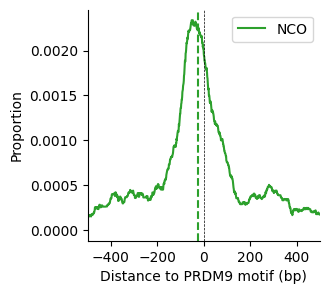

In [38]:
xs, H = inference.calculate_motif_distance_to_converted_snps_histogram(
    (NCO_clean_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

n_reads = len(NCO_clean_df.filter(pl.col("AA_motif_center_pos").is_not_null()))
est_mode = estimate_mode(np.concatenate([[x]*int(cnt) for x, cnt in zip(xs, H*n_reads) if cnt]))

#plt.plot(xs, H, alpha=0.8);
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(
    xs,
    scipy.ndimage.uniform_filter1d(H, 100),
    color=NCO_color,
    label="NCO",
)
#plt.plot(xs, H[::-1], color="teal", alpha=0.2);
#plt.title("NCOs - Distance to motif in A/A hotspot");
ax.set_xlim(-500,500);
ax.axvline(0, color="black", ls="--", lw=0.5, alpha=1);
ax.axvline(est_mode, color=NCO_color, ls="--");
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel("Distance to PRDM9 motif (bp)");
ax.set_ylabel("Proportion");
ax.legend();

In [38]:
inference.motif_distance_histogram_symmetry_permutation_testing(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    max_dist=30000,
    n_perms=10000,
    hist_func = inference.calculate_motif_distance_to_converted_snps_histogram,
    stat = "max_sq_cumsum",
)

np.float64(0.0)

## Distance to motif centers, per sample

### Using whole recombining interval

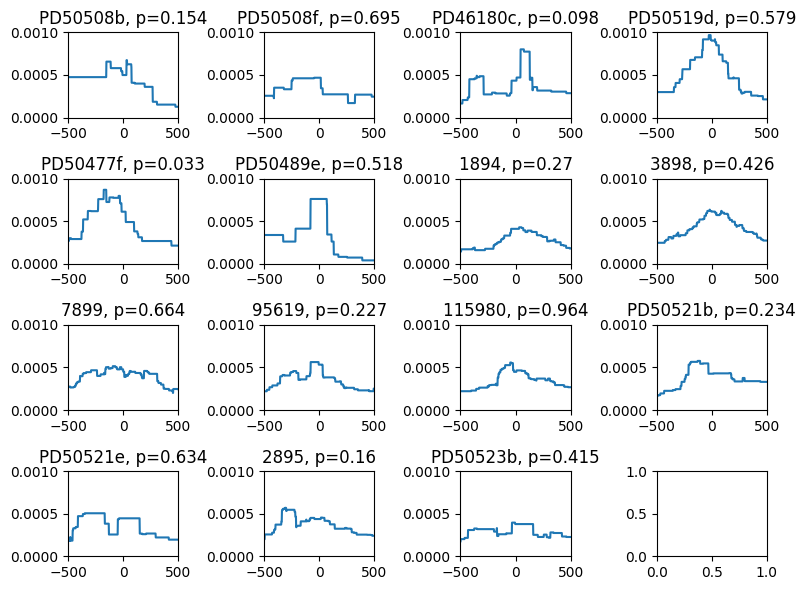

In [70]:
fig, axs = plt.subplots(4, 4, figsize=(8, 6))

motif_distances_per_sample_id = {}

for ax, sample_id in zip(axs.ravel(), sample_id_order):
    xs, H = inference.calculate_motif_distance_histogram(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id)
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    pval = inference.motif_distance_histogram_symmetry_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id) 
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    motif_distances_per_sample_id[sample_id] = H

    ax.plot(xs, H, label=sample_id);
    ax.set_title(f"{sample_id}, p={pval}")
    ax.set_xlim(-500, 500)
    ax.set_ylim(0, 0.001);

fig.tight_layout()

### Using just converted SNPs

TypeError: calculate_motif_distance_to_converted_snps_histogram() takes from 3 to 5 positional arguments but 6 were given

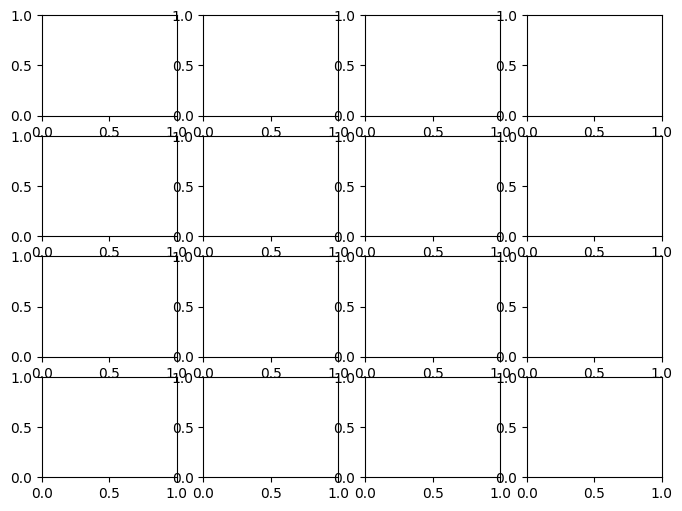

In [71]:
fig, axs = plt.subplots(4, 4, figsize=(8, 6))

motif_distances_per_sample_id = {}

for ax, sample_id in zip(axs.ravel(), sample_id_order):
    xs, H = inference.calculate_motif_distance_to_converted_snps_histogram(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id)
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    pval = inference.motif_distance_histogram_symmetry_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id) 
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        hist_func = inference.calculate_motif_distance_to_converted_snps_histogram,
        n_perms = 1000,
        stat = "max_sq_cumsum",
    )
    
    motif_distances_per_sample_id[sample_id] = H

    ax.plot(xs, H, label=sample_id);
    ax.plot(xs, scipy.ndimage.uniform_filter1d(H, 100)*10, label=sample_id);
    
    ax.set_title(f"{sample_id}, p={pval}")
    ax.set_xlim(-500, 500)
    ax.set_ylim(0, 0.06);

fig.tight_layout()

# Compare distance to motif between samples, in NCOs

### Using whole converted 

In [ ]:
sample_ids = sample_ids[:9]

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id1))
        ),
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id2))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        n_perms=1000,
        stat="sum_abs",
    )
    
    rows.append(
        [
            sample_id1, 
            sample_id2,
            pval,
        ]
    )
    
pairwise_motif_dists_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "perm_pval"
           ],
)       

In [ ]:
pairwise_motif_dists_nco_df.sort("perm_pval")

### Using converted SNPs

In [ ]:
sample_ids

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id1))
        ),
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id2))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        hist_func = inference.calculate_motif_distance_to_converted_snps_histogram,
        n_perms = 1000,
        stat = "max_sq_cumsum",
    )
    
    rows.append(
        [
            sample_id1, 
            sample_id2,
            pval,
        ]
    )
    
pairwise_motif_dists_nco_only_snps_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "perm_pval"
           ],
)       

In [ ]:
pairwise_motif_dists_nco_only_snps_df.sort("perm_pval")[:10]

# Compare DSB signal strengths between NCOs

In [57]:
sample_id_to_AA_heats = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter(pl.col("grch38_reference_start").is_not_null())
        .filter((pl.col("sample_id") == sample_id) & (pl.col("high_quality_classification_class") == "GC"))
    )
    heats = sdf["AA_heat"].fill_null(0)
    sample_id_to_AA_heats[sample_id] = heats.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    heats_1 = sample_id_to_AA_heats[sample_id1]
    heats_2 = sample_id_to_AA_heats[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(heats_1), 
            len(heats_2),
            scipy.stats.ks_2samp(heats_1, heats_2).pvalue,
            inference.permutation_testing([[heats_1, heats_2]], 1000),
            inference.permutation_testing([[heats_1[heats_1>0], heats_2[heats_2>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_1==0).sum(), (heats_1!=0).sum()],
                 [(heats_2==0).sum(), (heats_2!=0).sum()]],
            ).pvalue,
        ]
    )
    
pairwise_AA_heats_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

100%|██████████| 105/105 [00:52<00:00,  1.98it/s]
/tmp/ipykernel_3333776/2923569494.py:31: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pairwise_AA_heats_nco_df = pl.DataFrame(


In [58]:
{k:len(v) for k,v in sample_id_to_AA_heats.items()}

{'PD50477f': 159,
 'PD50519d': 140,
 'PD50508f': 24,
 'PD50523b': 316,
 'PD50521b': 74,
 'PD50508b': 93,
 'PD46180c': 170,
 'PD50521e': 162,
 'PD50489e': 103,
 '1894': 149,
 '3898': 151,
 '7899': 145,
 '95619': 111,
 '115980': 117,
 '2895': 105}

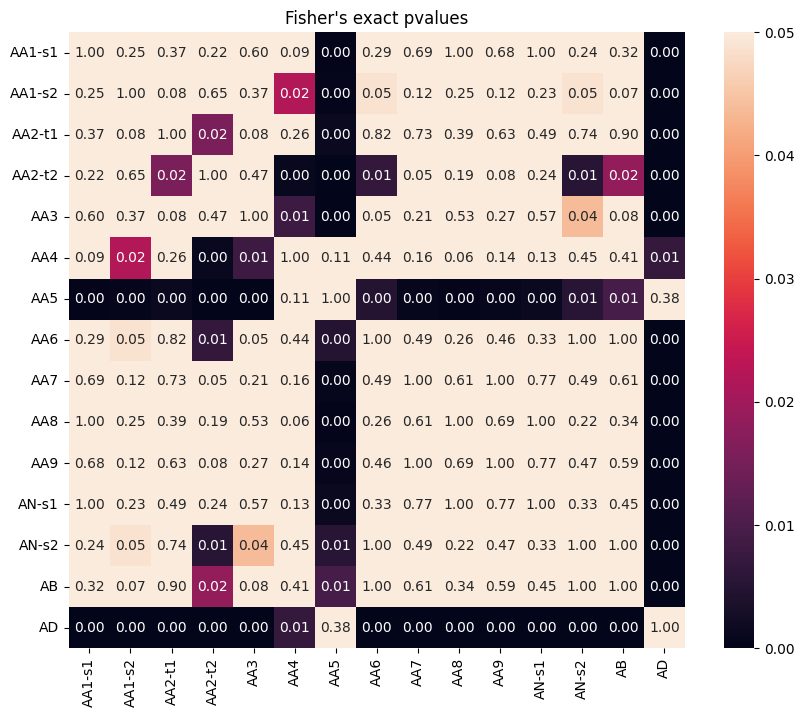

In [59]:
mat = []
for sample_id1 in sample_presentation_order[:-1]:
    row = []
    for sample_id2 in sample_presentation_order[:-1]:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_AA_heats_nco_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["heats_fisher_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
labels = [sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]]
mat = pd.DataFrame(mat, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
    annot=True,
    fmt=".2f",
    square=True,    
);

plt.title("Fisher's exact pvalues");

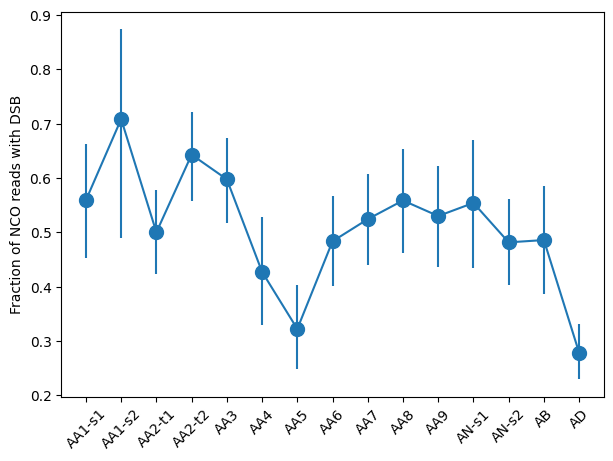

In [60]:
fig, ax = plt.subplots(figsize=(7,5))

mns = [(sample_id_to_AA_heats[s]>0).mean() for s in sample_id_order]
cis = [statsmodels.stats.proportion.proportion_confint(
    (sample_id_to_AA_heats[s]>0).sum(),
    len(sample_id_to_AA_heats[s]),
    method="beta",
) for s in sample_id_order]
    


ax.errorbar(
    x = np.arange(len(sample_id_order)),
    y = mns,
    yerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis, mns)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis, mns)],
    ],
    fmt=".-",
    ms=20,
    
);
ax.set_xticks(
    ticks = np.arange(len(sample_id_order)), 
    labels=[sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]], 
    rotation=45);
ax.set_ylabel("Fraction of NCO reads with DSB");

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id1 = "PD46180c"
sample_id2 = "PD50519d"

pval = pairwise_AA_heats_nco_df.filter(
    ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
    ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
)["heats_AD_perm_pvalue"].item(0)

sns.histplot(
    [
        pd.Series(sample_id_to_AA_heats[sample_id1], name=sample_id1),
        pd.Series(sample_id_to_AA_heats[sample_id2], name=sample_id2),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
plt.title(f"AD perm pval = {pval}");


# Test one sample vs the rest

## Sample level 

In [ ]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    pairs = [
        [
            sample_id_to_AA_heats[sample_id],
            sample_id_to_AA_heats[other_sample_id],
        ]
        for other_sample_id in sample_ids if other_sample_id != sample_id 
    ]
    lens_1 = sample_id_to_AA_heats[sample_id]
    rows.append(
        [
            sample_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
sample_vs_rest_nco_AA_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_in_sample", "AD_perm_pvalue"],
)

In [ ]:
sample_vs_rest_nco_AA_df.sort("AD_perm_pvalue")

In [ ]:
def test_fishers_exact_one_vs_rest(sample_ids):
    rows = []
    for sample_id in tqdm.tqdm(sample_ids):
        xx = sample_id_to_AA_heats[sample_id]
        sx = (xx>0).sum()
        yy = np.concatenate([sample_id_to_AA_heats[s] for s in sample_ids if s != sample_id])
        sy = (yy>0).sum()
        
        pval = scipy.stats.fisher_exact(
            [[sx, len(xx)-sx], [sy, len(yy)-sy]]
        ).pvalue
        
        label_id = sample_id_to_paper_label[sample_id]
        rows.append([sample_id, label_id, sx/len(xx), sy/len(yy), pval])
    
    df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "prop", "other_prop", "fisher_pval"]).sort("fisher_pval")
    return df
    

In [ ]:
test_fishers_exact_one_vs_rest(sample_ids)

In [ ]:
test_fishers_exact_one_vs_rest([s for s in sample_ids if sample_id_to_paper_label[s] not in ["AA5"]])

In [ ]:
def test_combined_fishers_exact_one_vs_rest(sample_ids):
    rows = []
    for sample_id in tqdm.tqdm(sample_ids):
        pvals = (pairwise_AA_heats_nco_df
            .filter((pl.col("sample_id1") == sample_id) | (pl.col("sample_id2") == sample_id))
            .filter(pl.col("sample_id1").is_in(sample_ids))
            .filter(pl.col("sample_id2").is_in(sample_ids))
            ["heats_fisher_pvalue"]
        )
        
        comb_fisher = scipy.stats.combine_pvalues(pvals, method="fisher").pvalue
        
        label_id = sample_id_to_paper_label[sample_id]
        rows.append([sample_id, label_id, comb_fisher])
    
    df = pl.DataFrame(rows, schema=["sample_id", "paper_label", "comb_fisher"]).sort("comb_fisher")
    return df
    
    

In [ ]:
test_combined_fishers_exact_one_vs_rest(sample_ids)

In [ ]:
test_combined_fishers_exact_one_vs_rest(rahbari_sample_ids)

In [ ]:
test_combined_fishers_exact_one_vs_rest([s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AN-s1"]])

In [ ]:
test_combined_fishers_exact_one_vs_rest([s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AN-s1", "AA1-s2"]])


In [ ]:
test_combined_fishers_exact_one_vs_rest(sudmant_sample_ids)

In [ ]:
test_combined_fishers_exact_one_vs_rest([s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AA5"]])

# GC-bias

## Prepare

### Make a dataframe of positions of all converted SNPs

In [61]:
%%time
converted_snps_df = (NCO_df
    .with_columns(
        (pl.col("idx_transitions").list.get(0)+1).alias("A"),
        (pl.col("idx_transitions").list.get(1) - pl.col("idx_transitions").list.get(0)).alias("B"),
    )
    .select(
        "sample_id",
        "chrom",
        "read_name",
        pl.col("snp_positions_on_read").list.slice(pl.col("A"), pl.col("B")).alias("start"),
        pl.col("AA_heat").is_not_null().alias("has_AA_DSB"),
    )
    .explode("start")
)

CPU times: user 8.31 ms, sys: 11.6 ms, total: 19.9 ms
Wall time: 6.76 ms


### Cross it with the sequences

In [62]:
dfs = []
for focal_sample_id in tqdm.tqdm(sample_ids):
    for chrom in aut_chrom_names:
        high_conf_snps_df = pl.scan_parquet(
            str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.high_confidence_snps.parquet")
        )
        
        df = (converted_snps_df
            .lazy()
            .filter(
                (pl.col("sample_id") == focal_sample_id) & \
                (pl.col("chrom") == chrom)
            )
            .join(
                (high_conf_snps_df
                    .select(
                        "read_name",
                        "start",
                        "refseq_start1",
                        "refseq_start2",    
                        "fits1_more",
                    )
                ),
                on=["read_name", "start"],
                how="left",
            )
        ).collect()
        dfs.append(df)
        
converted_snps_with_seq_df = pl.concat(dfs)

converted_snps_with_seq_df = converted_snps_with_seq_df.filter(
    (pl.col("refseq_start1").is_in(["G", "C"]) & pl.col("refseq_start2").is_in(["A", "T"])) |
    (pl.col("refseq_start2").is_in(["G", "C"]) & pl.col("refseq_start1").is_in(["A", "T"]))
)

100%|██████████| 15/15 [07:46<00:00, 31.12s/it]


In [63]:
print("# of converted SNPs:", len(converted_snps_with_seq_df))
print("# of NCO reads:", converted_snps_with_seq_df.n_unique(["read_name"]))

# of converted SNPs: 1000
# of NCO reads: 931


## What is the total GC bias?

In [64]:
import statsmodels.stats.proportion

def calculate_gc_stats(df, limited_sample_ids):
    gc_stats_df = (df
        .filter(pl.col("sample_id").is_in(limited_sample_ids))
        .select(
            pl.when(pl.col("fits1_more") == 1).then(pl.col("refseq_start1")).otherwise(pl.col("refseq_start2")).alias("base")
        )
        .group_by("base")
        .len()
    )
                   
    stats_D = dict(gc_stats_df.rows())

    n_GC = stats_D["G"] + stats_D["C"]
    n_AT = stats_D["A"] + stats_D["T"]
                   
    print("n_GC, n_AT:", n_GC, n_AT)
    print("GC-bias:", n_GC / (n_GC+n_AT))
    print("CI:", statsmodels.stats.proportion.proportion_confint(n_GC, (n_GC+n_AT), method="binom_test"))

In [65]:
calculate_gc_stats(converted_snps_with_seq_df, sample_ids)

n_GC, n_AT: 591 409
GC-bias: 0.591
CI: (0.560017992562098, 0.6215386501980439)


In [66]:
calculate_gc_stats(converted_snps_with_seq_df, rahbari_sample_ids)

n_GC, n_AT: 172 122
GC-bias: 0.5850340136054422
CI: (0.5272399439364951, 0.6413205185130975)


In [67]:
calculate_gc_stats(converted_snps_with_seq_df, sudmant_sample_ids)

n_GC, n_AT: 419 287
GC-bias: 0.5934844192634561
CI: (0.556680738347767, 0.6296614868521924)


## Limited to AA DSBs

In [68]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), sample_ids)

n_GC, n_AT: 338 183
GC-bias: 0.6487523992322457
CI: (0.6065866967385636, 0.6891745539891528)


In [ ]:
scipy.stats.fisher_exact([[452, 260], [884-452, 632-260]])

In [69]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), rahbari_sample_ids)

n_GC, n_AT: 110 63
GC-bias: 0.6358381502890174
CI: (0.5608063204978188, 0.7056005376916263)


In [70]:
calculate_gc_stats(converted_snps_with_seq_df.filter("has_AA_DSB"), sudmant_sample_ids)

n_GC, n_AT: 228 120
GC-bias: 0.6551724137931034
CI: (0.6035364151368908, 0.7042158568460952)


## Only multi-SNP tracts?

In [71]:
multi_df = (converted_snps_with_seq_df
    .join(
        converted_snps_with_seq_df.group_by("read_name").len().filter(pl.col("len") > 1).select("read_name"),
        on="read_name"
    )
)

In [72]:
print("# of converted SNPs:", len(multi_df))
print("# of NCO reads:", multi_df.n_unique(["read_name"]))

# of converted SNPs: 119
# of NCO reads: 50


In [73]:
calculate_gc_stats(multi_df, sample_ids)

n_GC, n_AT: 65 54
GC-bias: 0.5462184873949579
CI: (0.4536390257214299, 0.6348282066118668)


In [ ]:
scipy.stats.fisher_exact([[884-131, 632-93], [131, 93]])

## Long vs. Short

In [75]:
short_df = (NCO_df
    .filter((pl.col("idx_transitions").list.get(0)+1) == (pl.col("idx_transitions").list.get(1)))
)

long_df = (NCO_df
    .filter((pl.col("idx_transitions").list.get(0)+1) != (pl.col("idx_transitions").list.get(1)))
    .filter(
        (pl.col("snp_positions_on_read").list.get((pl.col("idx_transitions").list.get(1))) - 
        pl.col("snp_positions_on_read").list.get((pl.col("idx_transitions").list.get(0)+1))) > 500
    )
)

In [76]:
calculate_gc_stats(converted_snps_with_seq_df.join(short_df, on="read_name"), sample_ids)

n_GC, n_AT: 522 350
GC-bias: 0.5986238532110092
CI: (0.5653900691725054, 0.6307769161741995)


In [77]:
calculate_gc_stats(converted_snps_with_seq_df.join(long_df, on="read_name"), sample_ids)

n_GC, n_AT: 19 20
GC-bias: 0.48717948717948717
CI: (0.33167145022299205, 0.6422424808591589)


# ENCODE H3K4me3

In [ ]:
pairwise_nco_signals_df = inference.get_sample_pairwise_tests(
    sample_ids,
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

In [ ]:
pairwise_nco_signals_df.sort("AD_perm_pvalue").head()

In [ ]:
inference.plot_pairwise_results(pairwise_nco_signals_df, sample_presentation_order[:-1], vmax=0.05)

In [ ]:
inference.get_sample_vs_rest_tests(
    sample_ids,
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 10000,
)

In [ ]:
len(NCO_df)

In [85]:
def plot_h3k4_diffs(
    label_list1,
    label_list2,
    label_legend1 = "",
    label_legend2 = "",
    ax = None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    sample_ids1 = [k for k,v in sample_id_to_paper_label.items() if v in label_list1]
    sample_ids2 = [k for k,v in sample_id_to_paper_label.items() if v in label_list2]
    
    if label_legend1 == "":
        label_legend1 = ', '.join(sample_ids1)
    if label_legend2 == "":
        label_legend2 = ', '.join(sample_ids1)

    x1 = pd.Series(np.log10(NCO_df.filter(pl.col("sample_id").is_in(sample_ids1))["H3K4me3_signal_mean"]), name=label_legend1)
    x2 = pd.Series(np.log10(NCO_df.filter(pl.col("sample_id").is_in(sample_ids2))["H3K4me3_signal_mean"]), name=label_legend2)

    sns.histplot(
        data = [x1, x2],
        bins=25, #np.linspace(0, 2, 25),
        multiple="dodge",
        shrink=0.8,
        stat="proportion",
        common_norm=False,
        ax=ax,
    )
    
    sns.despine(ax=ax)

    ax.set_xlabel("H3K4me4 signal average across read");
    ax.set_xticks(
        ticks = np.arange(-2, 1),
        labels = [f"$10^{{{x}}}$" for x in np.arange(-2, 1)],
    );

/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


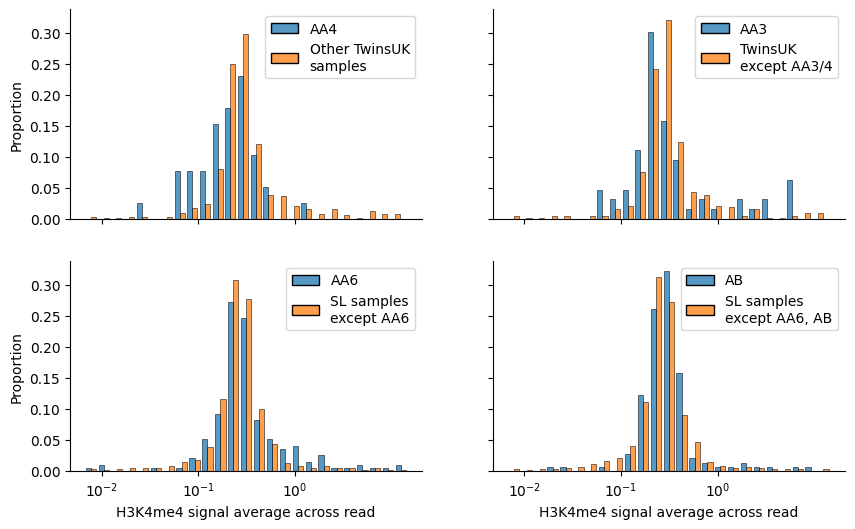

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

plot_h3k4_diffs(
    ["AA4"],
    [label for sample_id, label in sample_id_to_paper_label.items() \
         if sample_id in rahbari_sample_ids and label not in ["AA4"]],
    label_legend1 = "AA4",
    label_legend2 = "Other TwinsUK\nsamples",
    ax = axs[0,0],
)

plot_h3k4_diffs(
    ["AA3"],
    [label for sample_id, label in sample_id_to_paper_label.items() \
         if sample_id in rahbari_sample_ids and label not in ["AA4", "AA3"]],
    label_legend1 = "AA3",
    label_legend2 = "TwinsUK\nexcept AA3/4",
    ax = axs[0,1],
)

plot_h3k4_diffs(
    ["AA6"],
    [label for sample_id, label in sample_id_to_paper_label.items() \
         if sample_id in sudmant_sample_ids and label not in ["AA6"]],
    label_legend1 = "AA6",
    label_legend2 = "SL samples\nexcept AA6",
    ax = axs[1,0],
)

plot_h3k4_diffs(
    ["AB"],
    [label for sample_id, label in sample_id_to_paper_label.items() \
         if sample_id in sudmant_sample_ids and label not in ["AA6", "AB"]],
    label_legend1 = "AB",
    label_legend2 = "SL samples\nexcept AA6, AB",
    ax = axs[1,1],
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AA4"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 10000,
)

In [ ]:
plot_h3k4_diffs(
    ["AA3"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA4", "AA3"]],
    label_legend1 = "AA3",
    label_legend2 = "All other samples except AA4",
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AA4", "AA3"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 10000,
)

In [ ]:
plot_h3k4_diffs(
    ["AA2-t1"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA4", "AA3", "AA2-t1"]],
    label_legend1 = "AA2-t1",
    label_legend2 = "All other samples \nexcept AA3 and AA4",
)

In [ ]:
plot_h3k4_diffs(
    ["AA6"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA4", "AA3", "AA2-t1", "AA6"]],
    label_legend1 = "AA6",
    label_legend2 = "All other samples\nexcept AA3, AA4 \nand AA2-t1",
)

In [ ]:
plot_h3k4_diffs(
    ["AA8"],
    [label for label in sample_id_to_paper_label.values() if "AA" in label and label not in ["AA4", "AA3", "AA2-t1", "AA8", "AA6"]],
    label_legend1 = "AA8",
    label_legend2 = "All other samples",
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AA4", "AA3", "AA2-t1"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 10000,
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sample_ids if sample_id_to_paper_label[s] not in ["AA4", "AA3", "AA2-t1", "AA6"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 10000,
)

### Only Rahbari samples

In [ ]:
inference.get_sample_vs_rest_tests(
    rahbari_sample_ids,
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 10000,
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AA4"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in rahbari_sample_ids if sample_id_to_paper_label[s] not in ["AA4", "AA3"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

### Only Sudmant samples

In [ ]:
inference.get_sample_vs_rest_tests(
    sudmant_sample_ids,
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AA6"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

In [ ]:
inference.get_sample_vs_rest_tests(
    [s for s in sudmant_sample_ids if sample_id_to_paper_label[s] not in ["AA6", "AB"]],
    NCO_df,
    "H3K4me3_signal_mean",
    n_perms = 1000,
)

# ENCODE CTCF

In [ ]:
pairwise_nco_signals_df = inference.get_sample_pairwise_tests(
    sample_ids,
    NCO_df,
    "CTCF_signal_mean",
    n_perms = 1000,
)

In [ ]:
pairwise_nco_signals_df.sort("AD_perm_pvalue")

In [ ]:
inference.plot_pairwise_results(pairwise_nco_signals_df, sample_presentation_order[:-1], vmax=0.05)

In [ ]:
inference.get_sample_vs_rest_tests(
    sample_ids,
    NCO_df,
    "CTCF_signal_mean",
    n_perms = 1000,
) 

In [ ]:
inference.get_sample_vs_all_tests(
    sample_ids,
    NCO_df,
    dense_reads_with_detection_df.sample(fraction=1e-2),
    "CTCF_signal_mean",
    n_perms = 1000,
) 

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

focal_sample_id = "PD50519d"

sns.histplot(
    [
        pd.Series(dense_reads_with_detection_df["CTCF_signal_mean"][::100], name="All reads"),
        pd.Series(NCO_df.filter(pl.col("sample_id") == focal_sample_id)["CTCF_signal_mean"], 
                  name=sample_id_to_paper_label[focal_sample_id]),
    ], 
    bins=np.linspace(0,2,50),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Mean signal in detectible interval");


In [ ]:
inference.plot_histograms_samples(
    NCO_df,
    "CTCF_signal_mean",
    dense_reads_with_detection_df,
    bins = np.linspace(0, 2, 25), #np.linspace(-2, 2, 25)
    ylim_max = 0.15,
    xlabel = "",
    take_log10=False,
);

